(c) 2021, Franz Ludwig Kostelezky, IMTEK chair of simulation, \<info@kostelezky.com\>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from datetime import datetime

In [2]:
# import multichannel ecg data by R.Moss
data = pd.read_csv('./ECG_data/moss/MeasuredECG.txt', sep=" ", header=1)
data.columns = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

<IPython.core.display.Javascript object>


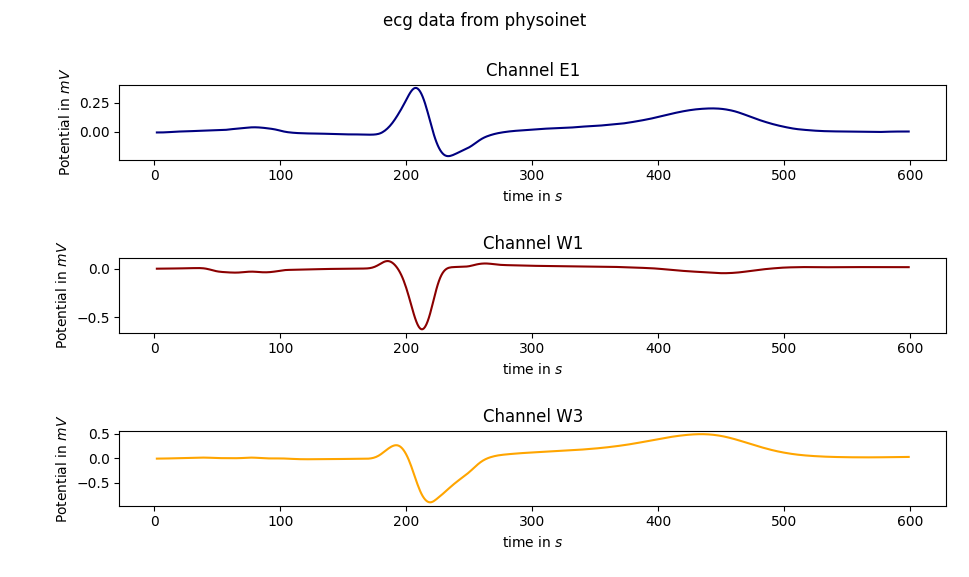

In [5]:
%matplotlib notebook
plt.subplot(3, 1, 1)
plt.suptitle('ecg data from physoinet')
plt.title('Channel E1')
plt.plot(data['time'], data['E1'], label='Channel E1', c='navy')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.subplot(3, 1, 2)
plt.title('Channel W1')
plt.plot(data['time'], data['W1'], label='Channel W1', c='darkred')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.subplot(3, 1, 3)
plt.title('Channel W3')
plt.plot(data['time'], data['W3'], label='Channel W3', c='orange')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.tight_layout()
plt.show()

In [6]:
# original time series
z_1 = np.array(data['E1'])
z_2 = np.array(data['W1'])
z_3 = np.array(data['W3'])

In [8]:
z_1_derivate = five_point_derivate_periodic(z_1)
z_2_derivate = five_point_derivate_periodic(z_2)
z_3_derivate = five_point_derivate_periodic(z_3)
z_1_min, z_1_max = min(z_1), max(z_1)
z_2_min, z_2_max = min(z_2), max(z_2)
z_3_min, z_3_max = min(z_3), max(z_3)

# fit to a 3d ode system
The time series $z_1, z_2, z_3$ will be fit to an system of connected ode's $\vec{y}$:

$$
y_1 = f_1(y_1, y_2, y_3; \vec{p})
\\
y_2 = f_2(y_1, y_2, y_3; \vec{q})
\\
y_3 = f_3(y_1, y_2, y_3; \vec{r})
$$

where the polynominal $f_i$ with it's grade $N_f=2$ is

$$
f_i(y_1, y_2, y_3) = p_0y_1+p_1y_2+p_2y_3 + p_3y_1^2+p_4y_1y_2+p_5y_1y_3+p_6y_2^2+p_7y_2y_3+p_8y_3^2
$$

In [7]:
def five_point_derivate_periodic(series):
    ''' Returns the 1D second order upwind derivate of a one dimensional
    time series using reflecting boundary conditions.
    '''

    series = np.array(series)
    dx = 1
    d_pos = (- 3 * series \
             + 4 * np.roll(series, shift=-1, axis=0) \
             - np.roll(series, shift=-2, axis=0)
            ) / (2 * dx)
    d_neg = (+ 3 * series \
             - 4 * np.roll(series, shift=1, axis=0) \
             + np.roll(series, shift=2, axis=0)
            ) / (2 * dx)
    derivate = d_pos
    derivate[-3::] = d_neg[-3::]

    return derivate

In [762]:
from itertools import permutations, product

In [830]:
def polynominal(dimension, grade):
    ''' returns the exponents of a polynominal
        of a given dimension to a given grade.
    '''
    # terminal condition
    if grade == 1:
        return np.identity(dimension)
        
    # get all possible combinations of grade x dimension
    tmp = product(range(grade + 1), repeat=dimension)
    tmp = list(tmp)
    
    # remove all which do not match grade
    tmp_ = []
    for i in range(len(tmp)):
        if np.sum(tmp[i]) == grade:
            tmp_.append(list(tmp[i]))
    
    # convert to full numpy array
    tmp_ = np.asarray([np.asarray(el) for el in tmp_])
    
    return np.append(polynominal(dimension, grade - 1), tmp_.T, axis=1)

In [837]:
polynominal(dimension=2, grade=3)

array([[1., 0., 0., 1., 2., 0., 1., 2., 3.],
       [0., 1., 2., 1., 0., 3., 2., 1., 0.]])

In [829]:
def polynominal_3d(grade):
    assert(0 < grade <= 4)
    p = [
            [1, 0, 0, 2, 1, 1, 0, 0, 0, 3, 2, 2, 1, 1, 1, 0, 0, 0, 0, 4, 3, 3, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
            [0, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 0, 2, 0, 1, 3, 2, 1, 0, 0, 1, 0, 2, 0, 1, 3, 0, 4, 3, 2, 2, 1, 0, 1, 3],
            [0, 0, 1, 0, 0, 1, 0, 1, 2, 0, 0, 1, 0, 2, 1, 0, 1, 2, 3, 0, 0, 1, 0, 2, 1, 0, 3, 0, 1, 2, 1, 3, 4, 2, 1],
        ] # |linear|  |--quadratic---|  |----------cubic-----------|  |-----------------grade 4--------------------|
    p = np.asarray(p)
    
    if grade == 1:
        return p[::, :3]
    if grade == 2:
        return p[::, :9]
    if grade == 3:
        return p[::, :19]
    if grade == 4:
        return p

In [633]:
def fit_coefficients_3d_variable(y_1, y_2, y_3, z, grade):
    polynominal = polynominal_3d(grade)
    
    len_polynominal = len(polynominal[0])
    
    a = np.ones((len_polynominal, len_polynominal))
    for i in range(len_polynominal):
        for j in range(len_polynominal):
            a[i][j] *= np.sum(y_1 ** (polynominal[0][j] + polynominal[0][i]) * \
                              y_2 ** (polynominal[1][j] + polynominal[1][i]) * \
                              y_3 ** (polynominal[2][j] + polynominal[2][i]))
    
    b = np.ones((len_polynominal, 1))
    for i in range(len_polynominal):
        b[i] *= np.sum(z * y_1 ** polynominal[0][i] * y_2 ** polynominal[1][i] * y_3 ** polynominal[2][i])
        
    #print(a)
    #print(b)
    
    return np.linalg.solve(a, b)

In [634]:
def convert_fit_coefficients_to_function(p, grade):
    if type(p) != np.ndarray: return print('Wrong coefficient type:', type(p), 'Expected numpy.ndarray.')

    print('Polynominal of grade %i detected' % (grade))

    y_1_poly, y_2_poly, y_3_poly = polynominal_3d(grade)

    def func(y_1, y_2, y_3):
        res = 0
        for i in range(len(p)):
            res += p[i] * y_1 ** y_1_poly[i] * y_2 ** y_2_poly[i] * y_3 ** y_3_poly[i]
        return res

    return func

In [635]:
grade = 4

p = fit_coefficients_3d_variable(z_1, z_2, z_3, five_point_derivate_periodic(z_1), grade)
q = fit_coefficients_3d_variable(z_1, z_2, z_3, five_point_derivate_periodic(z_2), grade)
r = fit_coefficients_3d_variable(z_1, z_2, z_3, five_point_derivate_periodic(z_3), grade)

In [636]:
p_ = convert_fit_coefficients_to_function(p, grade)
q_ = convert_fit_coefficients_to_function(q, grade)
r_ = convert_fit_coefficients_to_function(r, grade)

Polynominal of grade 4 detected
Polynominal of grade 4 detected
Polynominal of grade 4 detected


In [637]:
def func(t, x, fit_to_y_1, fit_to_y_2, fit_to_y_3):
    '''
    '''
    y = [0, 0, 0]
    
    y[0] = fit_to_y_1(x[0], x[1], x[2])[0]
    y[1] = fit_to_y_2(x[0], x[1], x[2])[0]
    y[2] = fit_to_y_3(x[0], x[1], x[2])[0]
    return y

In [651]:
T = len(z_1)

ivp = [0, 0, 0]
index_start = 100#207#195
ivp[0] += z_1[index_start]
ivp[1] += z_2[index_start]
ivp[2] += z_3[index_start]

sol = solve_ivp(func, [0, T], ivp, dense_output=True, args=[p_, q_, r_])

In [652]:
f = 1
t = np.linspace(0, T, T*f)
y_1, y_2, y_3 = sol.sol(t)

res = (t, y_1, y_2, y_3)

<IPython.core.display.Javascript object>


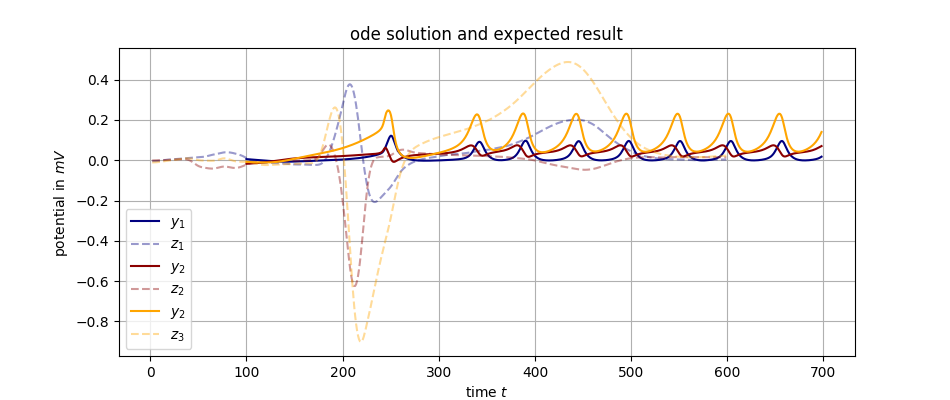

In [653]:
%matplotlib notebook
mi = T

fig = plt.figure(figsize=(9.5, 4))

ax = fig.add_subplot(1, 1, 1)
ax.plot(res[0][:mi]+index_start, res[1][:mi], color='navy', label='$y_1$')
ax.plot(data['time'], z_1, linestyle='--', color='navy', alpha=.4, label='$z_1$')
ax.plot(res[0][:mi]+index_start, res[2][:mi], color='darkred', label='$y_2$')
ax.plot(data['time'], z_2, linestyle='--', color='darkred', alpha=.4, label='$z_2$')
ax.plot(res[0][:mi]+index_start, res[3][:mi], color='orange', label='$y_2$')
ax.plot(data['time'], z_3, linestyle='--', color='orange', alpha=.4, label='$z_3$')
ax.grid()
plt.legend()
plt.xlabel('time $t$')
plt.ylabel('potential in $mV$')
plt.title('ode solution and expected result')

fig.show()

<IPython.core.display.Javascript object>


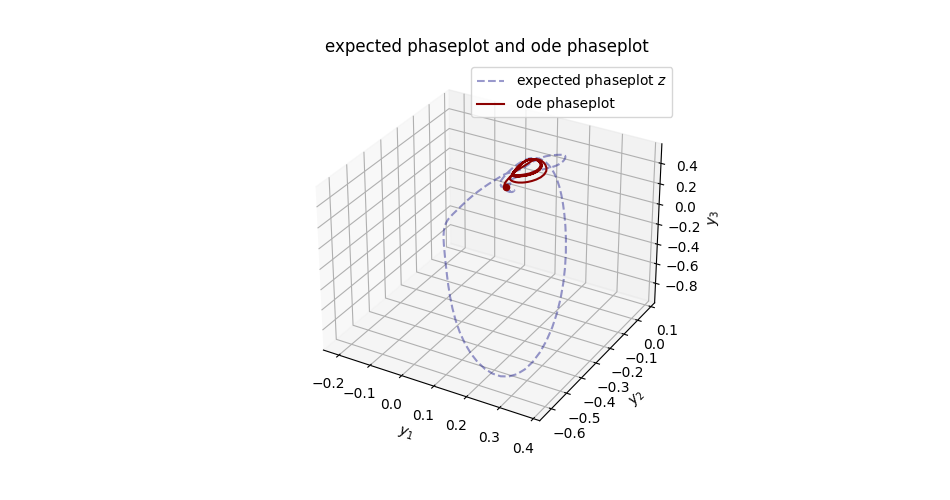

In [654]:
%matplotlib notebook
fig = plt.figure(figsize=(9.5, 5))
ax = fig.gca(projection='3d')
plt.title('expected phaseplot and ode phaseplot')

ax.plot(z_1, z_2, z_3, c='navy', label='expected phaseplot $z$', alpha=.4, linestyle='--')
plt.plot(res[1], res[2], res[3], c='darkred', label='ode phaseplot')

ax.scatter(res[1][0], res[2][0], res[3][0], color='darkred')

ax.set_xlabel('$y_1$')
ax.set_ylabel('$y_2$')
ax.set_zlabel('$y_3$')

plt.legend()
plt.show()

# Graveyard
old static functions

In [413]:
def fit_coefficients_3d(y_1, y_2, y_3, z, _):
    print('function "convert_coeffictents_to_fit_function" is deprecated and will be removed soon')
    
    pr = y_1 * y_2 * y_3 # product of all three, since this saves time
    
    a = [
         [np.sum(y_1 ** 2), np.sum(y_1 * y_2), np.sum(y_1 * y_3), np.sum(y_1 ** 3), np.sum(y_1 ** 2 * y_2), \
          np.sum(y_1 ** 2 * y_3), np.sum(y_1 * y_2 ** 2), np.sum(pr), np.sum(y_1 * y_3 ** 2)],
         [np.sum(y_1 * y_2), np.sum(y_2 ** 2), np.sum(y_2 * y_3), np.sum(y_1 ** 2 * y_2), np.sum(y_1 * y_2 ** 2), \
          np.sum(pr), np.sum(y_2 ** 3), np.sum(y_2 ** 2 * y_3), np.sum(y_2 * y_3 ** 2)],
         [np.sum(y_1 * y_3), np.sum(y_2 * y_3), np.sum(y_3 ** 2), np.sum(y_1 ** 2 * y_3), np.sum(pr), \
          np.sum(y_1 * y_3 ** 2), np.sum(y_2 ** 2 * y_3), np.sum(y_2 * y_3 ** 2), np.sum(y_3 ** 3)],
         [np.sum(y_1 ** 4), np.sum(y_1 ** 2 * y_2), np.sum(y_1 ** 2 * y_3), np.sum(y_1 ** 4), np.sum(y_1 ** 3 * y_2), \
          np.sum(y_1 ** 3 * y_3), np.sum(y_1 ** 2 * y_2 ** 2), np.sum(pr * y_1), np.sum(y_1 ** 2 * y_3 ** 2)],
         [np.sum(y_1 ** 2 * y_2), np.sum(y_1 * y_2 ** 2), np.sum(pr), np.sum(y_1 ** 3 * y_2), np.sum(y_1 ** 2 * y_2 ** 2), \
          np.sum(pr * y_1), np.sum(y_1 * y_2 ** 3), np.sum(pr * y_2), np.sum(pr * y_3)],
         [np.sum(y_1 ** 2 * y_3), np.sum(pr), np.sum(y_1 * y_3 ** 2), np.sum(y_1 ** 3 * y_3), np.sum(pr * y_1), \
          np.sum(y_1 ** 2 * y_3 ** 2), np.sum(pr * y_2), np.sum(pr * y_3), np.sum(y_1 * y_3 ** 3)],
         [np.sum(y_1 * y_2 ** 2), np.sum(y_2 ** 3), np.sum(y_2 ** 2 * y_3), np.sum(y_1 ** 2 * y_2 ** 2), \
          np.sum(y_1 * y_2 ** 3), np.sum(pr * y_2), np.sum(y_2 ** 4), np.sum(y_2 ** 3 * y_3), np.sum(y_2 ** 2 * y_3 ** 2)],
         [np.sum(pr), np.sum(y_2 ** 2 * y_3), np.sum(y_2 * y_3 ** 2), np.sum(pr * y_1), np.sum(pr * y_2), \
          np.sum(pr * y_3), np.sum(y_2 ** 3 * y_3), np.sum(y_2 ** 2 * y_3 ** 2), np.sum(y_2 * y_3 ** 3)],
         [np.sum(y_1 * y_3 ** 2), np.sum(y_2 * y_3 ** 2), np.sum(y_3 ** 3), np.sum(y_1 ** 2 * y_3 ** 2), \
          np.sum(pr * y_3), np.sum(y_1 * y_3 ** 3), np.sum(y_2 ** 2 * y_3 ** 2), np.sum(y_2 * y_3 ** 3), np.sum(y_3 ** 4)],
        ]
    b = [
         [np.sum(z * y_1)],
         [np.sum(z * y_2)],
         [np.sum(z * y_3)],
         [np.sum(z * y_1 ** 2)],
         [np.sum(z * y_1 * y_2)],
         [np.sum(z * y_1 * y_3)],
         [np.sum(z * y_2 ** 2)],
         [np.sum(z * y_2 * y_3)],
         [np.sum(z * y_3 ** 2)],
        ]
    
    #print(np.asarray(a))
    #print(np.asarray(b))
    
    return np.linalg.solve(a, b)

In [14]:
def convert_coeffictents_to_fit_function_static(p):
    assert(len(p) == 9)
    print('function "convert_coeffictents_to_fit_function" is deprecated and will be removed soon')
    def func(y_1, y_2, y_3):
        res = p[0] * y_1 + p[1] * y_2 + p[2] * y_3 + p[3] * y_1 ** 2 + p[4] * y_1 * y_2 + p[5] * y_1 * y_3 + \
              p[6] * y_2 ** 2 + p[7] * y_2 * y_3 + p[8] * y_3 ** 2
        return res
    return func